### PART 2, 1st Oct 2019 - 9th Mar 2020

In [5]:
import pandas as pd

# Load Part 2 file
df2 = 'QUB Data - Part 2.xlsx'

# Check available sheets
xls_part2 = pd.ExcelFile(df2)
print(xls_part2.sheet_names)

['Wind', 'Demand', 'Actual Prices']


##### Step 1.2 Load All Three Sheets

In [6]:
# Load each sheet
wind2_df = xls_part2.parse('Wind')
demand2_df = xls_part2.parse('Demand')
price2_df = xls_part2.parse('Actual Prices')

# Check the top rows
print("Wind Data:")
print(wind2_df.head())

print("\nDemand Data:")
print(demand2_df.head())

print("\nPrice Data:")
print(price2_df.head())

Wind Data:
   Start Date Start Time 30 Minute Period  Actual Wind (MW)
0  30/09/2019                    23:00:00              1279
1  30/09/2019                    23:30:00              1310
2  01/10/2019                    00:00:00              1282
3  01/10/2019                    00:30:00              1198
4  01/10/2019                    01:00:00              1169

Demand Data:
   Start Date Start Time 30 Minute Period  Actual Demand (MW)
0  30/09/2019                    23:00:00                3663
1  30/09/2019                    23:30:00                3479
2  01/10/2019                    00:00:00                3352
3  01/10/2019                    00:30:00                3245
4  01/10/2019                    01:00:00                3145

Price Data:
   Start Date      Time  DA Price  IDA1 Price  IDA2 Price  IDA3 Price  \
0  30/09/2019  23:00:00     32.29       24.00         NaN         NaN   
1  30/09/2019  23:30:00     32.29       31.73         NaN         NaN   
2  01/10/20

##### Step 2: Load and Prepare

In [7]:
# Load individual sheets
wind2_df = xls_part2.parse('Wind')
demand2_df = xls_part2.parse('Demand')
price2_df = xls_part2.parse('Actual Prices')

# Combine Date and Time into single Datetime column
def combine_datetime(df, date_col='Start Date', time_col='Time'):
    df['Datetime'] = pd.to_datetime(df[date_col] + ' ' + df[time_col], dayfirst=True)
    df = df.drop(columns=[date_col, time_col])
    return df

# Apply function
wind2_df = combine_datetime(wind2_df, date_col=wind2_df.columns[0], time_col=wind2_df.columns[1])
demand2_df = combine_datetime(demand2_df, date_col=demand2_df.columns[0], time_col=demand2_df.columns[1])
price2_df = combine_datetime(price2_df)

# Rename columns
wind2_df.columns = ['Actual_Wind', 'Datetime']
demand2_df.columns = ['Actual_Demand', 'Datetime']
price2_df.columns = ['DAM_Price', 'IDA1_Price', 'IDA2_Price', 'IDA3_Price', 'BM_Price', 'Datetime']

# Merge all into one master dataframe
df2 = wind2_df.merge(demand2_df, on='Datetime').merge(price2_df, on='Datetime')

# Sort by datetime
df2 = df2.sort_values('Datetime').reset_index(drop=True)

# Preview
df2.head()

,Actual_Wind,Datetime,Actual_Demand,DAM_Price,IDA1_Price,IDA2_Price,IDA3_Price,BM_Price
0,1279,2019-09-30 23:00:00,3663,32.29,24.00,NaN,NaN,24.44
1,1310,2019-09-30 23:30:00,3479,32.29,31.73,NaN,NaN,25.80
2,1282,2019-10-01 00:00:00,3352,27.97,32.67,NaN,NaN,22.07
3,1198,2019-10-01 00:30:00,3245,27.97,24.00,NaN,NaN,11.02
4,1169,2019-10-01 01:00:00,3145,24.73,24.00,NaN,NaN,5.96


#### STEP 3: Feature Engineering (Part 2)

In [8]:
# 1. Net Demand
df2['Net_Demand'] = df2['Actual_Demand'] - df2['Actual_Wind']

# 2. Hour of the day
df2['Hour'] = df2['Datetime'].dt.hour

# 3. (Optional) Day Type: Weekday or Weekend
df2['DayOfWeek'] = df2['Datetime'].dt.dayofweek  # Monday=0, Sunday=6
df2['Day_Type'] = df2['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Preview important columns
df2[['Datetime', 'Actual_Demand', 'Actual_Wind', 'Net_Demand', 'Hour', 'Day_Type']].head()

,Datetime,Actual_Demand,Actual_Wind,Net_Demand,Hour,Day_Type
0,2019-09-30 23:00:00,3663,1279,2384,23,Weekday
1,2019-09-30 23:30:00,3479,1310,2169,23,Weekday
2,2019-10-01 00:00:00,3352,1282,2070,0,Weekday
3,2019-10-01 00:30:00,3245,1198,2047,0,Weekday
4,2019-10-01 01:00:00,3145,1169,1976,1,Weekday


##### Step 4: Exploratory Data Analysis (EDA) for Part 2

##### 4.1 — Price Trends Over Time

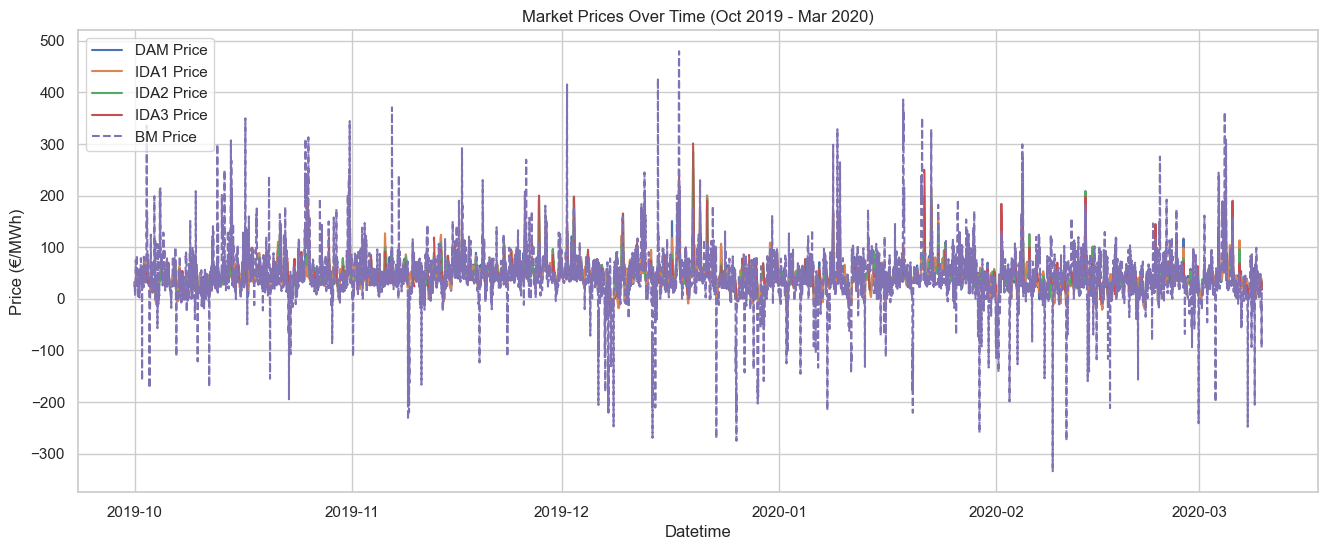

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16,6)

# Plot all market prices over time
plt.plot(df2['Datetime'], df2['DAM_Price'], label='DAM Price')
plt.plot(df2['Datetime'], df2['IDA1_Price'], label='IDA1 Price')
plt.plot(df2['Datetime'], df2['IDA2_Price'], label='IDA2 Price')
plt.plot(df2['Datetime'], df2['IDA3_Price'], label='IDA3 Price')
plt.plot(df2['Datetime'], df2['BM_Price'], label='BM Price', linestyle='--')
plt.title('Market Prices Over Time (Oct 2019 - Mar 2020)')
plt.xlabel('Datetime')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

##### 4.2 — Price Distribution by Hour of Day

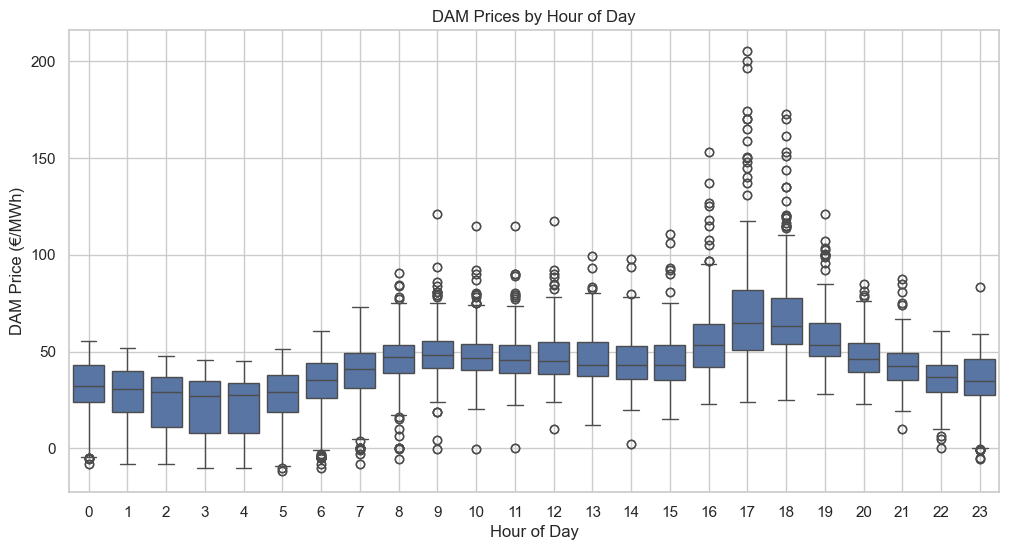

In [10]:
# Boxplot of DAM Prices by Hour
plt.figure(figsize=(12,6))
sns.boxplot(x=df2['Hour'], y=df2['DAM_Price'])
plt.title('DAM Prices by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('DAM Price (€/MWh)')
plt.grid(True)
plt.show()

##### 4.3 — Scatter Plot: Net Demand vs DAM Price

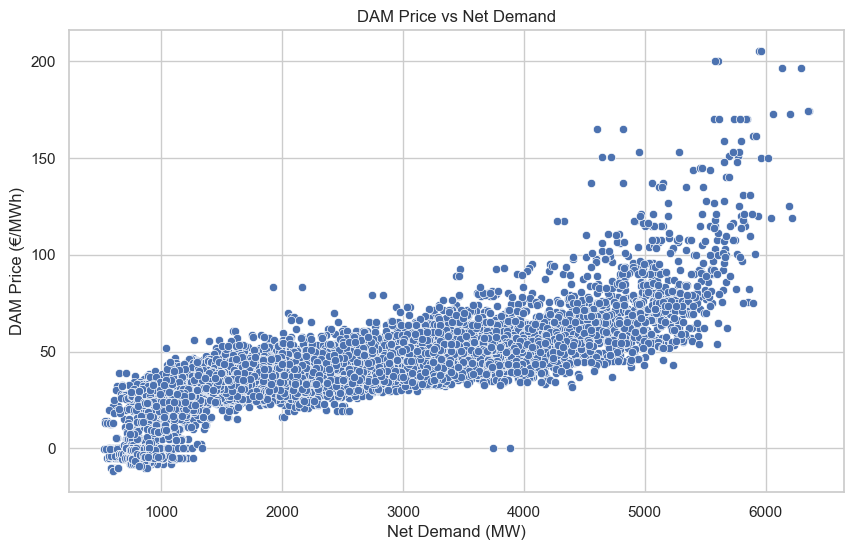

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2['Net_Demand'], y=df2['DAM_Price'])
plt.title('DAM Price vs Net Demand')
plt.xlabel('Net Demand (MW)')
plt.ylabel('DAM Price (€/MWh)')
plt.grid(True)
plt.show()

##### Step 5 — Strategy Simulation for Part 2

In [12]:
MW_needed = 100  # 100 MW per half-hour, same as before

# Strategy 1: Buy all in DAM
df2['Cost_DAM'] = df2['DAM_Price'] * MW_needed

# Strategy 2: Buy all in BM
df2['Cost_BM'] = df2['BM_Price'] * MW_needed

# Strategy 3: Split 50/50 between DAM and BM
df2['Cost_Split'] = (0.5 * df2['DAM_Price'] + 0.5 * df2['BM_Price']) * MW_needed

# Calculate total costs for each strategy
total_costs_part2 = {
    'Buy All in DAM': df2['Cost_DAM'].sum(),
    'Buy All in BM': df2['Cost_BM'].sum(),
    'Buy 50% DAM + 50% BM': df2['Cost_Split'].sum()
}

# Print total cost results
print("=== Total Cost for Each Strategy (Part 2: Oct 2019 - Mar 2020) ===")
for strategy, cost in total_costs_part2.items():
    print(f"{strategy}: €{cost:,.2f}")

=== Total Cost for Each Strategy (Part 2: Oct 2019 - Mar 2020) ===
Buy All in DAM: €32,884,151.80
Buy All in BM: €32,648,268.00
Buy 50% DAM + 50% BM: €32,766,209.90


In [15]:
# Export Part 2 data
df2.to_csv('Part2_Energia_Data.csv', index=False)